In [3]:
import os
from pathlib import Path
from PIL import Image
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

def convert_tif_to_png_with_split(source_dir, target_dir, train_ratio=0.8, preserve_structure=True, random_seed=42):
    """
    Convert TIF files to PNG and split into train/val sets.
    Handles masks with naming pattern: {basename}_mask.npy
    
    Args:
        source_dir: Source directory containing images/ and masks/ folders with TIF files
        target_dir: Target directory for PNG files with train/val split
        train_ratio: Ratio of training data (default: 0.8 for 80% train, 20% val)
        preserve_structure: If True, preserves subfolder structure within images/masks
        random_seed: Random seed for reproducible splits
    """
    source_path = Path(source_dir)
    target_path = Path(target_dir)
    
    # Find all TIF files in images folder
    tif_extensions = ['*.tif', '*.tiff', '*.TIF', '*.TIFF']
    image_files = []
    images_path = source_path / 'images'
    
    for ext in tif_extensions:
        image_files.extend(images_path.rglob(ext))
    
    if len(image_files) == 0:
        print(f"No TIF files found in {images_path}")
        return
    
    print(f"Found {len(image_files)} image files to convert")
    
    # Split into train/val
    train_files, val_files = train_test_split(
        image_files, 
        train_size=train_ratio, 
        random_state=random_seed
    )
    
    print(f"Train set: {len(train_files)} files")
    print(f"Val set: {len(val_files)} files")
    print(f"Target directory: {target_dir}")
    
    converted = 0
    errors = 0
    missing_masks = 0
    
    # Process both splits
    for split_name, file_list in [('train', train_files), ('val', val_files)]:
        print(f"\nProcessing {split_name} set...")
        
        for image_file in tqdm(file_list, desc=f"Converting {split_name}"):
            try:
                # Get relative path within images folder
                rel_path = image_file.relative_to(images_path)
                
                # Process image
                if preserve_structure:
                    image_output = target_path / split_name / 'images' / rel_path.parent / (rel_path.stem + '.png')
                else:
                    image_output = target_path / split_name / 'images' / (rel_path.stem + '.png')
                
                image_output.parent.mkdir(parents=True, exist_ok=True)
                
                # Convert image
                with Image.open(image_file) as img:
                    img_array = np.array(img)
                    
                    # Normalize 16-bit or float to 8-bit for images
                    if img.mode not in ['RGB', 'L', 'RGBA']:
                        if img.mode in ['I', 'I;16', 'F']:
                            img_array = ((img_array - img_array.min()) / 
                                        (img_array.max() - img_array.min()) * 255).astype(np.uint8)
                            img = Image.fromarray(img_array, mode='L')
                        else:
                            img = img.convert('L')
                    
                    img.save(image_output, 'PNG')
                
                # Process corresponding mask with {basename}_mask.npy naming
                # Get the base filename (without extension)
                base_name = rel_path.stem
                
                # Construct mask filename: {basename}_mask.npy
                mask_filename = f"{base_name}_mask.npy"
                
                # Construct full mask path preserving structure
                if preserve_structure:
                    mask_file = source_path / 'masks' / rel_path.parent / mask_filename
                else:
                    mask_file = source_path / 'masks' / mask_filename
                
                if mask_file.exists():
                    if preserve_structure:
                        mask_output = target_path / split_name / 'masks' / rel_path.parent / (base_name + '.png')
                    else:
                        mask_output = target_path / split_name / 'masks' / (base_name + '.png')
                    
                    mask_output.parent.mkdir(parents=True, exist_ok=True)
                    
                    # Load .npy file
                    mask_array = np.load(mask_file)
                    
                    # For masks: preserve exact integer values
                    if mask_array.dtype != np.uint8:
                        # Check if values are in valid range
                        if mask_array.max() <= 255:
                            mask_array = mask_array.astype(np.uint8)
                        else:
                            print(f"\nWarning: Mask {mask_file.name} has values > 255, normalizing...")
                            mask_array = ((mask_array - mask_array.min()) / 
                                         (mask_array.max() - mask_array.min()) * 255).astype(np.uint8)
                    
                    mask_img = Image.fromarray(mask_array, mode='L')
                    mask_img.save(mask_output, 'PNG')
                else:
                    print(f"\nWarning: Mask not found for {image_file.name}")
                    print(f"  Expected: {mask_file}")
                    missing_masks += 1
                
                converted += 1
                
            except Exception as e:
                print(f"\nError converting {image_file}: {str(e)}")
                errors += 1
    
    print(f"\n{'='*60}")
    print(f"Conversion complete!")
    print(f"Successfully converted: {converted} files")
    print(f"Missing masks: {missing_masks} files")
    print(f"Errors: {errors} files")
    print(f"{'='*60}")
    
    # Verify the conversion
    print("\n" + "="*60)
    print("VERIFICATION")
    print("="*60)
    
    for split in ['train', 'val']:
        for folder in ['images', 'masks']:
            path = target_path / split / folder
            if path.exists():
                png_count = len(list(path.glob('**/*.png')))
                print(f"{split}/{folder}: {png_count} PNG files")

if __name__ == "__main__":
    # Convert with train/val split
    convert_tif_to_png_with_split(
        source_dir='/pscratch/sd/x/xchong/sam3_finetune/seg_annotation_pipeline2/data',  # Your source folder with images/ and masks/
        target_dir='33folders_png',  # Output folder with train/val split
        train_ratio=0.8,  # 80% train, 20% val
        preserve_structure=True,  # Keep subfolder structure if any
        random_seed=42  # For reproducible splits
    )

Found 33 image files to convert
Train set: 26 files
Val set: 7 files
Target directory: 33folders_png

Processing train set...


Converting train: 100%|██████████| 26/26 [00:19<00:00,  1.37it/s]



Processing val set...


Converting val: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Conversion complete!
Successfully converted: 33 files
Missing masks: 0 files
Errors: 0 files

VERIFICATION
train/images: 26 PNG files
train/masks: 26 PNG files
val/images: 7 PNG files
val/masks: 7 PNG files


RANDOM INSPECTION: ONE FROM TRAIN, ONE FROM VAL

🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍
INSPECTING RANDOM TRAIN MASK
🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍

Found 26 PNG mask files in 33folders_png/train/masks
Randomly selected: 20211222_104840_petiole_test2_00400.png

Inspecting mask: 33folders_png/train/masks/20211222_104840_petiole_test2_00400.png

--- BASIC INFO ---
File: 20211222_104840_petiole_test2_00400.png
PIL Mode: L
Array shape: (2560, 2560)
Array dtype: uint8
Min value: 0
Max value: 255

--- UNIQUE VALUES ---
Number of unique values: 7
Unique values: [  0   1   2   3   4   6 255]

--- PIXEL COUNTS ---
Value 0: 1397123 pixels (21.32%)
Value 1: 1828740 pixels (27.90%)
Value 2: 37845 pixels (0.58%)
Value 3: 134433 pixels (2.05%)
Value 4: 704357 pixels (10.75%)
Value 6: 2037157 pixels (31.08%)
Value 255: 413945 pixels (6.32%)

--- SAMPLE PIXEL VALUES (top-left corner) ---
First 10x10 pixels:
[[255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 2

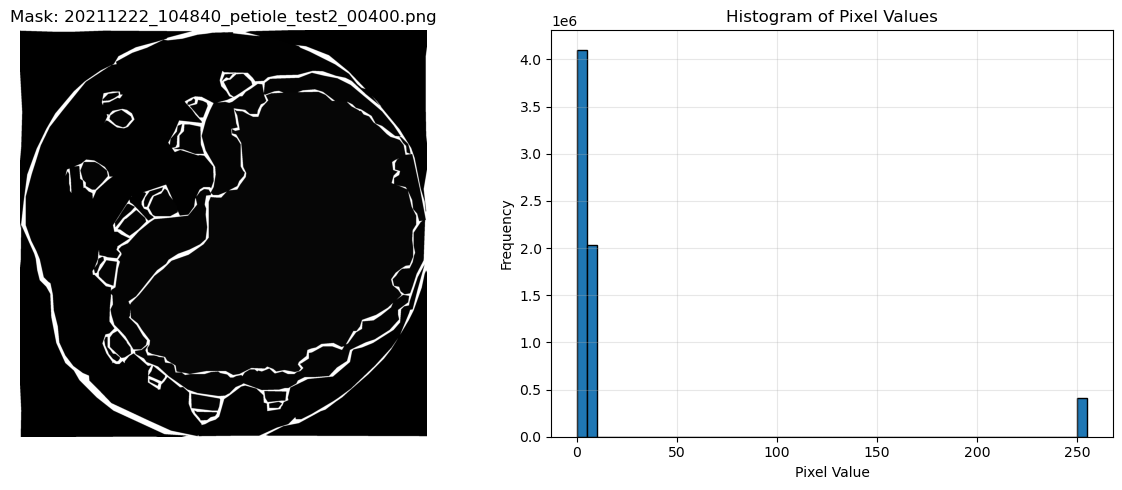



🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍
INSPECTING RANDOM VAL MASK
🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍

Found 7 PNG mask files in 33folders_png/val/masks
Randomly selected: 20211222_125057_petiole4_00300.png

Inspecting mask: 33folders_png/val/masks/20211222_125057_petiole4_00300.png

--- BASIC INFO ---
File: 20211222_125057_petiole4_00300.png
PIL Mode: L
Array shape: (2560, 2560)
Array dtype: uint8
Min value: 0
Max value: 255

--- UNIQUE VALUES ---
Number of unique values: 8
Unique values: [  0   1   2   3   4   5   6 255]

--- PIXEL COUNTS ---
Value 0: 3039339 pixels (46.38%)
Value 1: 1491522 pixels (22.76%)
Value 2: 47285 pixels (0.72%)
Value 3: 122545 pixels (1.87%)
Value 4: 517437 pixels (7.90%)
Value 5: 305303 pixels (4.66%)
Value 6: 610251 pixels (9.31%)
Value 255: 419918 pixels (6.41%)

--- SAMPLE PIXEL VALUES (top-left corner) ---
First 10x10 pixels:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0

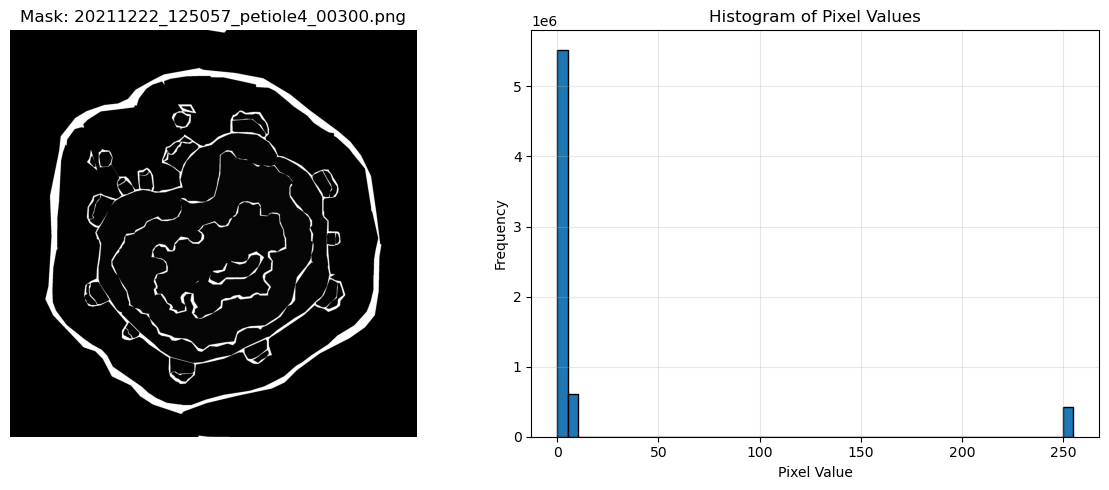

In [4]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import random

def inspect_mask(mask_path):
    """
    Thoroughly inspect a mask file to understand its format and values.
    
    Args:
        mask_path: Path to the mask file (PNG format)
    """
    print("=" * 70)
    print(f"Inspecting mask: {mask_path}")
    print("=" * 70)
    
    # Load mask (PNG only)
    mask = Image.open(mask_path)
    mask_array = np.array(mask)
    
    # Basic information
    print(f"\n--- BASIC INFO ---")
    print(f"File: {Path(mask_path).name}")
    print(f"PIL Mode: {mask.mode}")
    print(f"Array shape: {mask_array.shape}")
    print(f"Array dtype: {mask_array.dtype}")
    print(f"Min value: {mask_array.min()}")
    print(f"Max value: {mask_array.max()}")
    
    # Unique values
    print(f"\n--- UNIQUE VALUES ---")
    if len(mask_array.shape) == 2:
        # Single channel (grayscale)
        unique_values = np.unique(mask_array)
        print(f"Number of unique values: {len(unique_values)}")
        print(f"Unique values: {unique_values}")
        
        # Count pixels for each value
        print(f"\n--- PIXEL COUNTS ---")
        for val in unique_values:
            count = np.sum(mask_array == val)
            percentage = count / mask_array.size * 100
            print(f"Value {val}: {count} pixels ({percentage:.2f}%)")
    
    elif len(mask_array.shape) == 3:
        # Multi-channel (RGB/RGBA)
        print(f"Channels: {mask_array.shape[2]}")
        
        # Get unique colors
        unique_colors = np.unique(mask_array.reshape(-1, mask_array.shape[2]), axis=0)
        print(f"Number of unique colors: {len(unique_colors)}")
        print(f"\n--- UNIQUE COLORS (RGB tuples) ---")
        
        for i, color in enumerate(unique_colors):
            # Count pixels with this color
            if mask_array.shape[2] == 3:
                mask_matching = np.all(mask_array == color, axis=2)
            else:  # RGBA
                mask_matching = np.all(mask_array[:, :, :3] == color[:3], axis=2)
            
            count = np.sum(mask_matching)
            percentage = count / (mask_array.shape[0] * mask_array.shape[1]) * 100
            
            if mask_array.shape[2] == 3:
                print(f"Color {i}: RGB{tuple(color)} - {count} pixels ({percentage:.2f}%)")
            else:
                print(f"Color {i}: RGBA{tuple(color)} - {count} pixels ({percentage:.2f}%)")
    
    # Sample some pixel values
    print(f"\n--- SAMPLE PIXEL VALUES (top-left corner) ---")
    if len(mask_array.shape) == 2:
        print("First 10x10 pixels:")
        print(mask_array[:10, :10])
    else:
        print("First 5 pixels (showing RGB values):")
        for i in range(min(5, mask_array.shape[0])):
            print(f"Row {i}: {mask_array[i, :5]}")
    
    # Visualization
    print(f"\n--- VISUALIZATION ---")
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Original mask
    if len(mask_array.shape) == 2:
        axes[0].imshow(mask_array, cmap='gray', vmin=0, vmax=mask_array.max())
    else:
        axes[0].imshow(mask_array)
    axes[0].set_title(f'Mask: {Path(mask_path).name}')
    axes[0].axis('off')
    
    # Histogram
    if len(mask_array.shape) == 2:
        axes[1].hist(mask_array.flatten(), bins=50, edgecolor='black')
        axes[1].set_xlabel('Pixel Value')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('Histogram of Pixel Values')
        axes[1].grid(True, alpha=0.3)
    else:
        # For RGB, show histogram of each channel
        colors = ['red', 'green', 'blue']
        for i in range(min(3, mask_array.shape[2])):
            axes[1].hist(mask_array[:, :, i].flatten(), bins=50, 
                        alpha=0.5, label=colors[i], color=colors[i])
        axes[1].set_xlabel('Pixel Value')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('Histogram per Channel')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return mask_array


def inspect_random_mask(mask_dir, seed=None):
    """
    Randomly select and inspect one PNG mask from a directory.
    
    Args:
        mask_dir: Directory containing PNG mask files
        seed: Random seed for reproducibility (optional)
    """
    # Look for PNG files only
    mask_paths = list(Path(mask_dir).glob("*.png"))
    
    if len(mask_paths) == 0:
        print(f"No PNG mask files found in {mask_dir}")
        return None
    
    print(f"Found {len(mask_paths)} PNG mask files in {mask_dir}")
    
    # Set seed for reproducibility if provided
    if seed is not None:
        random.seed(seed)
    
    # Randomly select one mask
    selected_mask = random.choice(mask_paths)
    print(f"Randomly selected: {selected_mask.name}\n")
    
    return inspect_mask(selected_mask)


def inspect_random_from_train_and_val(base_dir, seed=None):
    """
    Randomly select and inspect one PNG mask from train and one from val.
    
    Args:
        base_dir: Base directory containing train/ and val/ folders
        seed: Random seed for reproducibility (optional)
    """
    base_path = Path(base_dir)
    
    # Check train folder
    train_masks_dir = base_path / "train" / "masks"
    if not train_masks_dir.exists():
        print(f"Train masks directory not found: {train_masks_dir}")
        return
    
    # Check val folder
    val_masks_dir = base_path / "val" / "masks"
    if not val_masks_dir.exists():
        print(f"Val masks directory not found: {val_masks_dir}")
        return
    
    print("\n" + "🔍" * 35)
    print("INSPECTING RANDOM TRAIN MASK")
    print("🔍" * 35 + "\n")
    inspect_random_mask(train_masks_dir, seed=seed)
    
    print("\n\n" + "🔍" * 35)
    print("INSPECTING RANDOM VAL MASK")
    print("🔍" * 35 + "\n")
    inspect_random_mask(val_masks_dir, seed=seed)


def inspect_multiple_random_masks(mask_dir, num_samples=3, seed=None):
    """
    Randomly select and inspect multiple PNG masks from a directory.
    
    Args:
        mask_dir: Directory containing PNG mask files
        num_samples: Number of masks to inspect
        seed: Random seed for reproducibility (optional)
    """
    # Look for PNG files only
    mask_paths = list(Path(mask_dir).glob("*.png"))
    
    if len(mask_paths) == 0:
        print(f"No PNG mask files found in {mask_dir}")
        return
    
    print(f"\nFound {len(mask_paths)} PNG mask files")
    
    # Set seed for reproducibility if provided
    if seed is not None:
        random.seed(seed)
    
    # Randomly select samples
    num_to_inspect = min(num_samples, len(mask_paths))
    selected_masks = random.sample(mask_paths, num_to_inspect)
    
    print(f"Randomly selected {num_to_inspect} masks to inspect...\n")
    
    for i, mask_path in enumerate(selected_masks):
        mask_array = inspect_mask(mask_path)
        if i < num_to_inspect - 1:
            print("\n" + "="*70 + "\n")


if __name__ == "__main__":
    # Main use case: Randomly inspect one PNG mask from train and one from val
    print("="*70)
    print("RANDOM INSPECTION: ONE FROM TRAIN, ONE FROM VAL")
    print("="*70)
    inspect_random_from_train_and_val("33folders_png", seed=42)
    
    # Alternative examples:
    
    # Example 1: Inspect one random PNG mask from train only
    # print("\n\nEXAMPLE 1: Random PNG mask from train")
    # inspect_random_mask("4folders_png/train/masks", seed=42)
    
    # Example 2: Inspect one random PNG mask from val only
    # print("\n\nEXAMPLE 2: Random PNG mask from val")
    # inspect_random_mask("4folders_png/val/masks", seed=42)
    
    # Example 3: Inspect multiple random PNG masks from train
    # print("\n\nEXAMPLE 3: Multiple random PNG masks from train")
    # inspect_multiple_random_masks("4folders_png/train/masks", num_samples=3, seed=42)

RANDOM INSPECTION: ONE FROM TRAIN, ONE FROM VAL

🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍
INSPECTING RANDOM TRAIN MASK
🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍

Found 26 PNG mask files in 33folders_png/train/masks
Randomly selected: 20211222_104840_petiole_test2_00400.png

Inspecting mask: 33folders_png/train/masks/20211222_104840_petiole_test2_00400.png

--- BASIC INFO ---
File: 20211222_104840_petiole_test2_00400.png
PIL Mode: L
Array shape: (2560, 2560)
Array dtype: uint8
Min value: 0
Max value: 255

--- UNIQUE VALUES ---
Number of unique values: 7
Unique values: [  0   1   2   3   4   6 255]

--- PIXEL COUNTS ---
Class 0 (Background): 1397123 pixels (21.32%) - RGB[128, 128, 128]
Class 1 (Cortex): 1828740 pixels (27.90%) - RGB[0, 0, 255]
Class 2 (Phloem Fibers): 37845 pixels (0.58%) - RGB[0, 255, 0]
Class 3 (Phloem): 134433 pixels (2.05%) - RGB[128, 0, 128]
Class 4 (Xylem vessels): 704357 pixels (10.75%) - RGB[255, 0, 0]
Class 6 (Water-based Pith cells): 2037157 pixels (31.08%) - RGB[255, 165

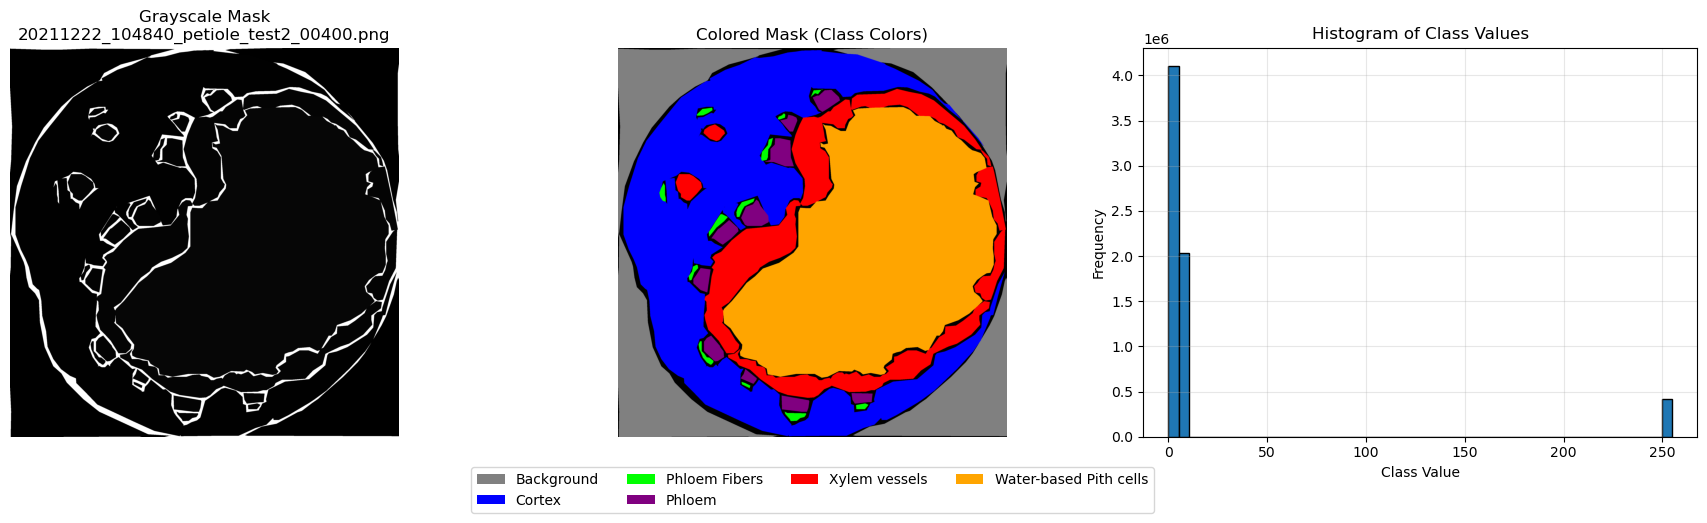



🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍
INSPECTING RANDOM VAL MASK
🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍

Found 7 PNG mask files in 33folders_png/val/masks
Randomly selected: 20211222_125057_petiole4_00300.png

Inspecting mask: 33folders_png/val/masks/20211222_125057_petiole4_00300.png

--- BASIC INFO ---
File: 20211222_125057_petiole4_00300.png
PIL Mode: L
Array shape: (2560, 2560)
Array dtype: uint8
Min value: 0
Max value: 255

--- UNIQUE VALUES ---
Number of unique values: 8
Unique values: [  0   1   2   3   4   5   6 255]

--- PIXEL COUNTS ---
Class 0 (Background): 3039339 pixels (46.38%) - RGB[128, 128, 128]
Class 1 (Cortex): 1491522 pixels (22.76%) - RGB[0, 0, 255]
Class 2 (Phloem Fibers): 47285 pixels (0.72%) - RGB[0, 255, 0]
Class 3 (Phloem): 122545 pixels (1.87%) - RGB[128, 0, 128]
Class 4 (Xylem vessels): 517437 pixels (7.90%) - RGB[255, 0, 0]
Class 5 (Air-based Pith cells): 305303 pixels (4.66%) - RGB[255, 255, 0]
Class 6 (Water-based Pith cells): 610251 pixels (9.31%) - RGB[255

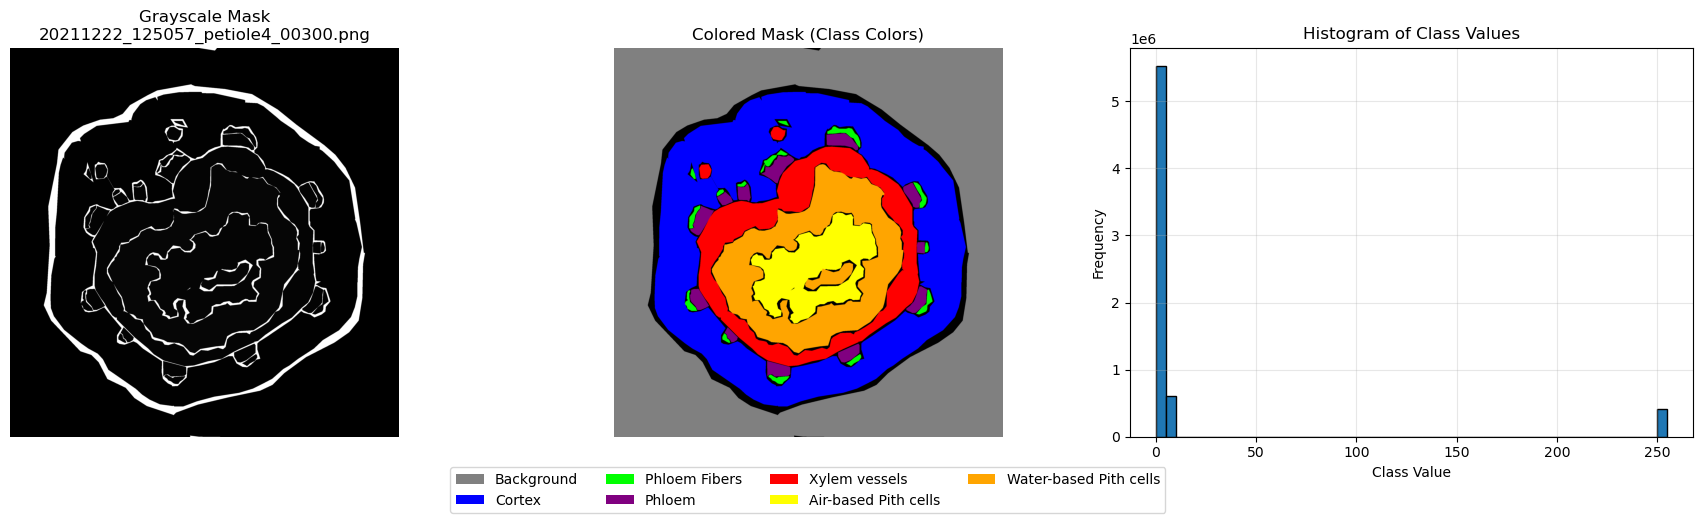

In [5]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import random

# Define class colors
CLASS_COLORS = {
    0: [128, 128, 128],  # Gray - Background
    1: [0, 0, 255],      # Blue - Cortex
    2: [0, 255, 0],      # Green - Phloem Fibers
    3: [128, 0, 128],    # Purple - Phloem
    4: [255, 0, 0],      # Red - Xylem vessels
    5: [255, 255, 0],    # Yellow - Air-based Pith cells
    6: [255, 165, 0],    # Orange - Water-based Pith cells
}

CLASS_NAMES = {
    0: "Background",
    1: "Cortex",
    2: "Phloem Fibers",
    3: "Phloem",
    4: "Xylem vessels",
    5: "Air-based Pith cells",
    6: "Water-based Pith cells",
}

def mask_to_color(mask_array):
    """
    Convert a grayscale mask to RGB using class colors.
    
    Args:
        mask_array: 2D numpy array with class indices
    
    Returns:
        RGB image as numpy array
    """
    h, w = mask_array.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    
    for class_id, color in CLASS_COLORS.items():
        color_mask[mask_array == class_id] = color
    
    return color_mask


def inspect_mask(mask_path):
    """
    Thoroughly inspect a mask file to understand its format and values.
    
    Args:
        mask_path: Path to the mask file (PNG format)
    """
    print("=" * 70)
    print(f"Inspecting mask: {mask_path}")
    print("=" * 70)
    
    # Load mask (PNG only)
    mask = Image.open(mask_path)
    mask_array = np.array(mask)
    
    # Basic information
    print(f"\n--- BASIC INFO ---")
    print(f"File: {Path(mask_path).name}")
    print(f"PIL Mode: {mask.mode}")
    print(f"Array shape: {mask_array.shape}")
    print(f"Array dtype: {mask_array.dtype}")
    print(f"Min value: {mask_array.min()}")
    print(f"Max value: {mask_array.max()}")
    
    # Unique values
    print(f"\n--- UNIQUE VALUES ---")
    if len(mask_array.shape) == 2:
        # Single channel (grayscale)
        unique_values = np.unique(mask_array)
        print(f"Number of unique values: {len(unique_values)}")
        print(f"Unique values: {unique_values}")
        
        # Count pixels for each value with class names
        print(f"\n--- PIXEL COUNTS ---")
        for val in unique_values:
            count = np.sum(mask_array == val)
            percentage = count / mask_array.size * 100
            class_name = CLASS_NAMES.get(val, "Unknown")
            color = CLASS_COLORS.get(val, [0, 0, 0])
            print(f"Class {val} ({class_name}): {count} pixels ({percentage:.2f}%) - RGB{color}")
    
    elif len(mask_array.shape) == 3:
        # Multi-channel (RGB/RGBA)
        print(f"Channels: {mask_array.shape[2]}")
        
        # Get unique colors
        unique_colors = np.unique(mask_array.reshape(-1, mask_array.shape[2]), axis=0)
        print(f"Number of unique colors: {len(unique_colors)}")
        print(f"\n--- UNIQUE COLORS (RGB tuples) ---")
        
        for i, color in enumerate(unique_colors):
            # Count pixels with this color
            if mask_array.shape[2] == 3:
                mask_matching = np.all(mask_array == color, axis=2)
            else:  # RGBA
                mask_matching = np.all(mask_array[:, :, :3] == color[:3], axis=2)
            
            count = np.sum(mask_matching)
            percentage = count / (mask_array.shape[0] * mask_array.shape[1]) * 100
            
            if mask_array.shape[2] == 3:
                print(f"Color {i}: RGB{tuple(color)} - {count} pixels ({percentage:.2f}%)")
            else:
                print(f"Color {i}: RGBA{tuple(color)} - {count} pixels ({percentage:.2f}%)")
    
    # Sample some pixel values
    print(f"\n--- SAMPLE PIXEL VALUES (top-left corner) ---")
    if len(mask_array.shape) == 2:
        print("First 10x10 pixels:")
        print(mask_array[:10, :10])
    else:
        print("First 5 pixels (showing RGB values):")
        for i in range(min(5, mask_array.shape[0])):
            print(f"Row {i}: {mask_array[i, :5]}")
    
    # Visualization
    print(f"\n--- VISUALIZATION ---")
    
    if len(mask_array.shape) == 2:
        # For grayscale masks, show both grayscale and colored versions
        color_mask = mask_to_color(mask_array)
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Grayscale mask
        axes[0].imshow(mask_array, cmap='gray', vmin=0, vmax=mask_array.max())
        axes[0].set_title(f'Grayscale Mask\n{Path(mask_path).name}')
        axes[0].axis('off')
        
        # Colored mask
        axes[1].imshow(color_mask)
        axes[1].set_title('Colored Mask (Class Colors)')
        axes[1].axis('off')
        
        # Histogram
        axes[2].hist(mask_array.flatten(), bins=50, edgecolor='black')
        axes[2].set_xlabel('Class Value')
        axes[2].set_ylabel('Frequency')
        axes[2].set_title('Histogram of Class Values')
        axes[2].grid(True, alpha=0.3)
        
    else:
        # For RGB masks
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        axes[0].imshow(mask_array)
        axes[0].set_title(f'Mask: {Path(mask_path).name}')
        axes[0].axis('off')
        
        # Histogram per channel
        colors = ['red', 'green', 'blue']
        for i in range(min(3, mask_array.shape[2])):
            axes[1].hist(mask_array[:, :, i].flatten(), bins=50, 
                        alpha=0.5, label=colors[i], color=colors[i])
        axes[1].set_xlabel('Pixel Value')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('Histogram per Channel')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    
    # Add legend for classes
    if len(mask_array.shape) == 2:
        unique_classes = np.unique(mask_array)
        legend_elements = []
        for class_id in unique_classes:
            if class_id in CLASS_COLORS:
                color = np.array(CLASS_COLORS[class_id]) / 255.0
                name = CLASS_NAMES.get(class_id, f"Class {class_id}")
                legend_elements.append(plt.Rectangle((0, 0), 1, 1, fc=color, label=name))
        
        if legend_elements:
            fig.legend(handles=legend_elements, loc='lower center', 
                      ncol=min(4, len(legend_elements)), bbox_to_anchor=(0.5, -0.05))
    
    plt.tight_layout()
    plt.show()
    
    return mask_array


def inspect_random_mask(mask_dir, seed=None):
    """
    Randomly select and inspect one PNG mask from a directory.
    
    Args:
        mask_dir: Directory containing PNG mask files
        seed: Random seed for reproducibility (optional)
    """
    # Look for PNG files only
    mask_paths = list(Path(mask_dir).glob("*.png"))
    
    if len(mask_paths) == 0:
        print(f"No PNG mask files found in {mask_dir}")
        return None
    
    print(f"Found {len(mask_paths)} PNG mask files in {mask_dir}")
    
    # Set seed for reproducibility if provided
    if seed is not None:
        random.seed(seed)
    
    # Randomly select one mask
    selected_mask = random.choice(mask_paths)
    print(f"Randomly selected: {selected_mask.name}\n")
    
    return inspect_mask(selected_mask)


def inspect_random_from_train_and_val(base_dir, seed=None):
    """
    Randomly select and inspect one PNG mask from train and one from val.
    
    Args:
        base_dir: Base directory containing train/ and val/ folders
        seed: Random seed for reproducibility (optional)
    """
    base_path = Path(base_dir)
    
    # Check train folder
    train_masks_dir = base_path / "train" / "masks"
    if not train_masks_dir.exists():
        print(f"Train masks directory not found: {train_masks_dir}")
        return
    
    # Check val folder
    val_masks_dir = base_path / "val" / "masks"
    if not val_masks_dir.exists():
        print(f"Val masks directory not found: {val_masks_dir}")
        return
    
    print("\n" + "🔍" * 35)
    print("INSPECTING RANDOM TRAIN MASK")
    print("🔍" * 35 + "\n")
    inspect_random_mask(train_masks_dir, seed=seed)
    
    print("\n\n" + "🔍" * 35)
    print("INSPECTING RANDOM VAL MASK")
    print("🔍" * 35 + "\n")
    inspect_random_mask(val_masks_dir, seed=seed)


def inspect_multiple_random_masks(mask_dir, num_samples=3, seed=None):
    """
    Randomly select and inspect multiple PNG masks from a directory.
    
    Args:
        mask_dir: Directory containing PNG mask files
        num_samples: Number of masks to inspect
        seed: Random seed for reproducibility (optional)
    """
    # Look for PNG files only
    mask_paths = list(Path(mask_dir).glob("*.png"))
    
    if len(mask_paths) == 0:
        print(f"No PNG mask files found in {mask_dir}")
        return
    
    print(f"\nFound {len(mask_paths)} PNG mask files")
    
    # Set seed for reproducibility if provided
    if seed is not None:
        random.seed(seed)
    
    # Randomly select samples
    num_to_inspect = min(num_samples, len(mask_paths))
    selected_masks = random.sample(mask_paths, num_to_inspect)
    
    print(f"Randomly selected {num_to_inspect} masks to inspect...\n")
    
    for i, mask_path in enumerate(selected_masks):
        mask_array = inspect_mask(mask_path)
        if i < num_to_inspect - 1:
            print("\n" + "="*70 + "\n")


def visualize_mask_with_image(image_path, mask_path):
    """
    Visualize an image alongside its mask in both grayscale and colored versions.
    
    Args:
        image_path: Path to the image file
        mask_path: Path to the mask file
    """
    # Load image and mask
    image = np.array(Image.open(image_path))
    mask = np.array(Image.open(mask_path))
    
    # Convert mask to color
    color_mask = mask_to_color(mask)
    
    # Create overlay (50% image, 50% colored mask)
    if len(image.shape) == 2:
        image_rgb = np.stack([image] * 3, axis=-1)
    else:
        image_rgb = image
    
    overlay = (0.5 * image_rgb + 0.5 * color_mask).astype(np.uint8)
    
    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    axes[0, 0].imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(mask, cmap='gray')
    axes[0, 1].set_title('Mask (Grayscale)')
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(color_mask)
    axes[1, 0].set_title('Mask (Colored by Class)')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(overlay)
    axes[1, 1].set_title('Overlay (Image + Colored Mask)')
    axes[1, 1].axis('off')
    
    # Add legend
    unique_classes = np.unique(mask)
    legend_elements = []
    for class_id in unique_classes:
        if class_id in CLASS_COLORS:
            color = np.array(CLASS_COLORS[class_id]) / 255.0
            name = CLASS_NAMES.get(class_id, f"Class {class_id}")
            legend_elements.append(plt.Rectangle((0, 0), 1, 1, fc=color, label=name))
    
    if legend_elements:
        fig.legend(handles=legend_elements, loc='lower center', 
                  ncol=min(4, len(legend_elements)), bbox_to_anchor=(0.5, -0.02))
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Main use case: Randomly inspect one PNG mask from train and one from val
    print("="*70)
    print("RANDOM INSPECTION: ONE FROM TRAIN, ONE FROM VAL")
    print("="*70)
    inspect_random_from_train_and_val("33folders_png", seed=42)
    
    # Alternative examples:
    
    # Example 1: Inspect one random PNG mask from train only
    # print("\n\nEXAMPLE 1: Random PNG mask from train")
    # inspect_random_mask("4folders_png/train/masks", seed=42)
    
    # Example 2: Visualize image with its mask
    # print("\n\nEXAMPLE 2: Visualize image with mask")
    # visualize_mask_with_image(
    #     image_path="4folders_png/train/images/sand1_recon_01212.png",
    #     mask_path="4folders_png/train/masks/sand1_recon_01212.png"
    # )